# Post processing and visualizing mandyoc data: Yield Strength Envelopes

The following notebook allows the user to visualize the YSE according to a given number of time instants (e.g.: `instants = [0, 500, 1000]` Myr). `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import gc
import sys
import glob
import string
import numpy as np
import pylab as pl
import xarray as xr
import pandas as pd
import mpl_toolkits.axisartist
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)


path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/mandyoc-scripts/functions")
from mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset, plot_property, _extract_interface, find_nearest

In [20]:
def calc_mean_temperaure_region(data, Nz, xx, begin, end):
    '''
    This funcition select a region in x direction in a 2D array and calculates the horizontal mean

    Parameters
    ----------

    data: `numpy.ndarray`

    Nz: int
        Number of points in Z direction

    xx: numpy.ndarray
        2D grid with x cordinates

    begin: float
        Start point

    end: float
        End point

    Returns
    -------
    arr: `numpy.ndarray`
        Array containing the horizontal mean of selected region
    '''

    x_region = (xx >= begin) & (xx <= end)
    Nx_aux = len(x_region[0][x_region[0]==True])
    data_sel = data[x_region].reshape(Nz, Nx_aux)
    data_sel_mean = np.mean(data_sel, axis=1)
    
    return data_sel_mean
def Tp_estimate(mean_temp, z, zbot, ztop):
    zcond = (z<=zbot+40) & (z>=ztop+40) #considering air layer

    zcut = z[zcond]
    tcut = mean_temp[zcond]

    params = curve_fit(fit_func, zcut, tcut)
    [a, b] = params[0]

    tfit = a*z + b #temeprature fitted

    #find the mantle potential temperature
    idx = np.where(z == 40.0)[0][0] #air thickness = 40 
    Tp = int(np.round(tfit[idx], 0))

    return Tp, tfit

def fit_func(x, a, b):
    return a*x + b

def calc_and_plot_YSE(ax, T_mean_region, z,
                      clc = 10,
                      thickness_sa = 40 * 1.0e3,
                      thickness_upper_crust = 20 * 1.0e3,
                      thickness_lower_crust = 15 * 1.0e3,
                      thickness_litho = 80 * 1.0e3,):
###################################################################################

    # Creating YSE

    L = thickness_litho #select from z axis of the scenario
    N = int(2*thickness_litho/1.0e3 + 1)
    z_yse = np.linspace(0, L, N)
    dz_yse = z_yse[1]-z_yse[0]

    f = interp1d(z, T_mean_region)
    T_interp = f(z_yse/1.0e3)

    rho = np.zeros_like(z_yse)

    #conditions for regions
    uc = (z_yse <= thickness_upper_crust)
    lc = (z_yse > thickness_upper_crust) & (z_yse <= thickness_upper_crust + thickness_lower_crust)
    lm = (z_yse > thickness_upper_crust + thickness_lower_crust)

    rho[uc]=2700.0
    rho[lc]=2800.0
    rho[lm]=3354.0
    g = 10.0

    P = 0.0
    Paux = 0.0
    for i in range(1, N):
        Paux += dz_yse*rho[i]*g
        P = np.append(P, Paux)

    phi = 2.0*np.pi/180.0
    c0 = 4.0E6
    sigma_min = c0 * np.cos(phi) + P * np.sin(phi)

    phi = 15.0*np.pi/180.0
    c0 = 20.0E6
    sigma_max = c0 * np.cos(phi) + P * np.sin(phi)

    #rheological params
    Q = np.zeros_like(z_yse)
    A = np.zeros_like(z_yse)
    n = np.zeros_like(z_yse)
    V = np.zeros_like(z_yse)
    C = np.zeros_like(z_yse)

    Q[uc]=222000.0
    Q[lc]=222000.0
    Q[lm]=540000.0

    A[uc]=8.574E-28
    A[lc]=8.574E-28
    A[lm]=2.4168E-15

    n[uc]=4.0
    n[lc]=4.0
    n[lm]=3.5

    V[uc]=0.0
    V[lc]=0.0
    V[lm]=25.0E-6

    #strain rate (sr)
    sr = 1.0E-15

    #gas constant
    R = 8.314

    #print(n)

    #Temperature Kelvin
    TK = T_interp + 273

    #Viscosity
    #Choosing C for layers
    C[uc]=1.0
    C[lc] = clc
    C[lm]=1.0
    
    visc = C * A**(-1./n) * sr**((1.0-n)/n)*np.exp((Q + V*P)/(n*R*TK))

    sigma_v = visc * sr

    cond = sigma_v>sigma_max
    sigma_v[cond]=sigma_max[cond]

    ax.plot(sigma_v/1.0E9, z_yse/1000, linestyle='-', color='black', alpha=0.7)

    
    cr = 255.
    color_uc = (228./cr, 156./cr, 124./cr)
    color_lc = (240./cr, 209./cr, 188./cr)
    color_lit = (155./cr, 194./cr, 155./cr)
    color_ast = (207./cr, 226./cr, 205./cr)

    #filling inside YSE
    ax.fill_betweenx(z_yse[uc]/1000, z_yse[uc]*0, sigma_v[uc]/1.0E9, color=color_uc, ec="k")
    ax.fill_betweenx(z_yse[lc]/1000, z_yse[lc]*0, sigma_v[lc]/1.0E9, color=color_lc, ec="k")
    ax.fill_betweenx(z_yse[lm]/1000, z_yse[lm]*0, sigma_v[lm]/1.0E9, color=color_lit, ec="k")

def calc_temper_profiles(data, Lx, Nz, xx, Lcraton=1200, onlycraton=False, shift=0.0):
    xcenter = (Lx/2)/1.0e3 + shift/1.0e3

    # keel_mean_l = calc_mean_temperaure_region(data, Nz, xx, xcenter - Lcraton/2, xcenter - Lcraton/6)
    # keel_mean_c = calc_mean_temperaure_region(data, Nz, xx, xcenter - Lcraton/12, xcenter + Lcraton/12)
    # keel_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + Lcraton/6, xcenter + Lcraton/2)

    keel_mean_l = calc_mean_temperaure_region(data, Nz, xx, xcenter - 350, xcenter - 250)
    keel_mean_c = calc_mean_temperaure_region(data, Nz, xx, xcenter - 50, xcenter + 50)
    keel_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + 250, xcenter + 350)

    out_mean_l = calc_mean_temperaure_region(data, Nz, xx, 200, xcenter - Lcraton/2 - 200)
    out_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + Lcraton/2 + 200, Lx/1.03 - 200)

    if(onlycraton):
        temper_profiles = [keel_mean_l, keel_mean_c, keel_mean_r]
    else:
        temper_profiles = [out_mean_l, keel_mean_l, keel_mean_c, keel_mean_r, out_mean_r]

    return temper_profiles

In [21]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}"

scenarios = [f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf",
             f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo",
             f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbwo",
             ]

print(f"Scernarios:")
for scenario in scenarios:
    print(f"{scenario.split('/')[-1]}")

Scernarios:
keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf
keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo
keel_stable_DT200_HprodAst_Lx4000km_ck_mbwo


In [22]:
dataset0 = xr.open_dataset(f'{scenarios[0]}/_output_temperature.nc')
dataset1 = xr.open_dataset(f'{scenarios[1]}/_output_temperature.nc')
dataset2 = xr.open_dataset(f'{scenarios[2]}/_output_temperature.nc')

Nx = int(dataset0.nx)
Nz = int(dataset0.nz)
Lx = float(dataset0.lx)
Lz = float(dataset0.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(dataset0.info)

<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (time: 401, x: 401, z: 71)
Coordinates:
  * time         (time) float64 0.0 2.5 5.0 7.5 10.0 ... 992.5 995.0 997.5 1e+03
    step         (time) int32 ...
  * x            (x) float64 0.0 1e+04 2e+04 3e+04 ... 3.98e+06 3.99e+06 4e+06
  * z            (z) float64 -7e+05 -6.9e+05 -6.8e+05 ... -2e+04 -1e+04 0.0
Data variables:
    temperature  (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                401
    nz:                                71
    lx:                                4000000.0
    lz:                                700000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:                        W/m^3
    viscosity_units:                   Pa s
    strain_rate_units:                 s^(-1)
    pressure_u

In [23]:
len(scenarios)

3

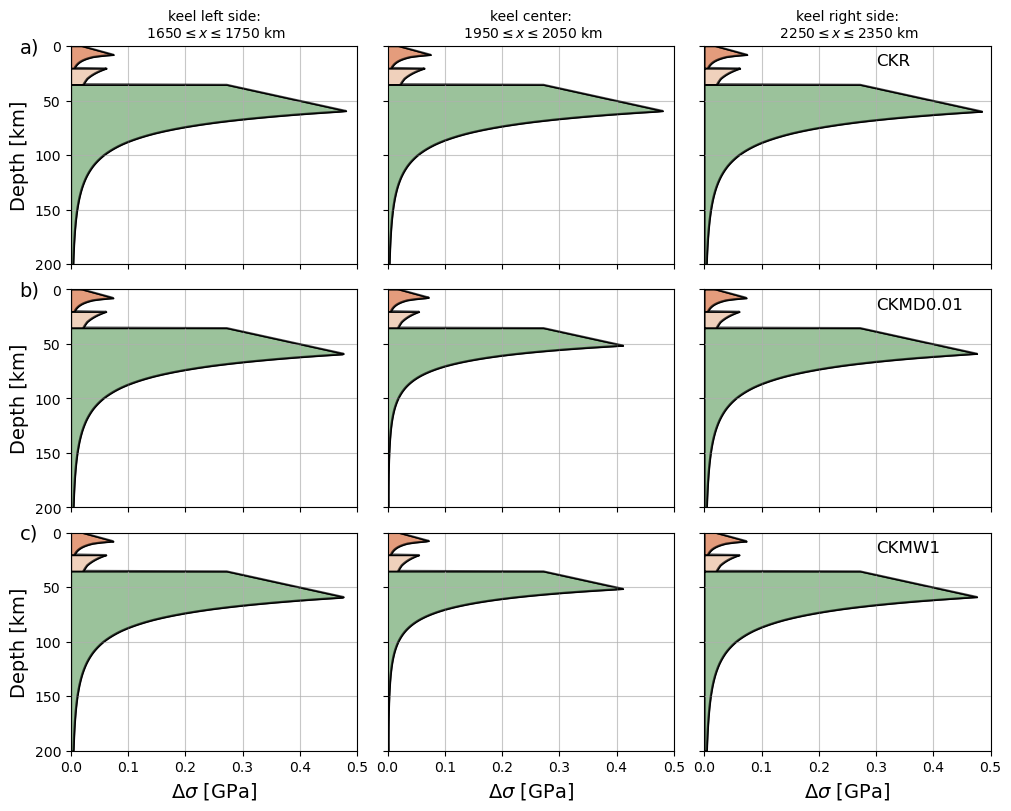

In [29]:
# instants = [0, 500, 1000] #Myr
instants = [1000]


##############################################################################################################
#Creating figure and subplots
plt.close()
# gridspec_kw={'height_ratios':[0.3,0.5]}


# onlycraton = False
onlycraton = True

if(onlycraton):
    fig_length = 10
    fig_height = 8 #6 minimum
    ncols = 3
else:
    fig_length = 10
    fig_height = 6 #6 minimum
    ncols = 5

if(len(instants) > 1):
    fig_height = (2.0)*(len(instants) + 1) #4 is minimum

    fig, axs = plt.subplots(len(instants)*len(scenarios), ncols, figsize=(fig_length, fig_height), sharex=True, sharey=True, constrained_layout=True)
else:
    fig, axs = plt.subplots(len(instants)*len(scenarios), ncols, figsize=(fig_length, fig_height), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten() #flatten the axs array to make it easier to iterate over the subplots

alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(instants)]

Lcraton = 1200.0 #km
shift = 0.0 #km

if(onlycraton):
    Hlits = [200.0e3, 200.0e3, 200.0e3]
else:
    Hlits = [80.0e3, 200.0e3, 200.0e3, 200.0e3, 80.0e3]

thickness_sa = 40.0e3
z_aux = z - thickness_sa/1.0e3
cond_aux = z_aux >= 0
Lcraton = 1200.0 #km
xcenter = (Lx/2)/1.0e3 + shift/1.0e3

# time = np.round(dataset0.time[i].values, 2)

for instant, i in zip(instants, range(len(instants))):
    idx = find_nearest(dataset0.time, instant)

    data0 = dataset0.temperature[idx].values.T #Nz vs Nx
    data1 = dataset1.temperature[idx].values.T #Nz vs Nx
    data2 = dataset2.temperature[idx].values.T #Nz vs Nx
    
    temperature_profiles0 = calc_temper_profiles(data0, Lx, Nz, xx, onlycraton=onlycraton)
    temperature_profiles1 = calc_temper_profiles(data1, Lx, Nz, xx, onlycraton=onlycraton)
    temperature_profiles2 = calc_temper_profiles(data2, Lx, Nz, xx, onlycraton=onlycraton)

    for ax0, ax1, ax2, temp_profile0, temp_profile1, thickness_litho in zip(axs[0:len(Hlits)], axs[len(Hlits): 2*len(Hlits)], axs[2*len(Hlits): 3*len(Hlits)], temperature_profiles0, temperature_profiles1, Hlits):
        calc_and_plot_YSE(ax0, temp_profile0[cond_aux], z_aux[cond_aux], thickness_litho=thickness_litho)
        calc_and_plot_YSE(ax1, temp_profile1[cond_aux], z_aux[cond_aux], thickness_litho=thickness_litho)
        calc_and_plot_YSE(ax2, temp_profile1[cond_aux], z_aux[cond_aux], thickness_litho=thickness_litho)

        # ax0.plot(range(10), range(10), color='k')
        # ax1.plot(range(10), range(10), color='r')

if(onlycraton):
    # locations = [f'keel left side:\n ${int(xcenter - 600)} \leq x \leq {int( xcenter - 200)}$ km',
    #             f'keel center:\n ${int(xcenter - 100)} \leq x \leq {int( xcenter + 100)}$ km',
    #             f'keel right side:\n ${int(xcenter + 200)} \leq x \leq {int( xcenter + 600)}$ km',
    #             ]
    
    locations = [f'keel left side:\n ${int(xcenter - 350)} \leq x \leq {int( xcenter - 250)}$ km',
                f'keel center:\n ${int(xcenter - 50)} \leq x \leq {int( xcenter + 50)}$ km',
                f'keel right side:\n ${int(xcenter + 250)} \leq x \leq {int( xcenter + 350)}$ km',
                ]

else:
    locations = [f'outside keel left side:\n $200 \leq x \leq {int(xcenter - 800)}$ km',
                f'keel left side:\n ${int(xcenter - 350)} \leq x \leq {int( xcenter - 250)}$ km',
                f'keel center:\n ${int(xcenter - 50)} \leq x \leq {int( xcenter + 50)}$ km',
                f'keel right side:\n ${int(xcenter + 250)} \leq x \leq {int( xcenter + 350)}$ km',
                f'outside keel right side:\n ${int(xcenter + 800)} \leq x \leq {int(Lx/1.0e3 - 200)}$ km'
                ]
    
    # locations = [f'outside keel left side:\n $200 \leq x \leq {int(xcenter - 800)}$ km',
    #             f'keel left side:\n ${int(xcenter - 600)} \leq x \leq {int( xcenter - 200)}$ km',
    #             f'keel center:\n ${int(xcenter - 100)} \leq x \leq {int( xcenter + 100)}$ km',
    #             f'keel right side:\n ${int(xcenter + 200)} \leq x \leq {int( xcenter + 600)}$ km',
    #             f'outside keel right side:\n ${int(xcenter + 800)} \leq x \leq {int(Lx/1.0e3 - 200)}$ km'
    #             ]

label_fsize = 14
for ax0, ax1, ax2, location in zip(axs[0:len(Hlits)], axs[len(Hlits): 2*len(Hlits)], axs[2*len(Hlits): 3*len(Hlits)], locations):
    ax0.grid("k", alpha=0.7)
    ax1.grid("k", alpha=0.7)
    ax2.grid("k", alpha=0.7)
    ax0.set_title(f'{location}', fontsize=10)
    ax2.set_xlabel(r'$\Delta\sigma$ [GPa]', fontsize=label_fsize)

if(onlycraton):
    xpos = -0.18
    ypos = 0.995
    fsize = 14
else:
    xpos = -0.48
    ypos = 0.995
    fsize = 14

axs[0].text(xpos, ypos, 'a)', color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[0].transAxes)

axs[len(Hlits)].text(xpos, ypos, 'b)', color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[len(Hlits)].transAxes)

axs[2*len(Hlits)].text(xpos, ypos, 'c)', color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[2*len(Hlits)].transAxes)

xpos = 0.6
ypos = 0.93
fsize = 12

axs[len(Hlits)-1].text(xpos, ypos, r'CKR', color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[len(Hlits)-1].transAxes)

axs[2*len(Hlits)-1].text(xpos, ypos,  r'CKMD0.01', color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[2*len(Hlits)-1].transAxes)

axs[3*len(Hlits)-1].text(xpos, ypos,  r'CKMW1', color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[3*len(Hlits)-1].transAxes)


# for ax in axs:
#     ax.set_box_aspect(3)

axs[0].set_xlim([0, 0.5])
axs[0].set_xticks(np.linspace(0, 0.5, 6))

# axs[0].set_ylim([200, 0])
# axs[0].set_yticks(np.linspace(0, 200, 11))
    
# axs[0].set_xlim([0, 0.5])
if(onlycraton):
    axs[0].set_ylim([200, 0])
else:
    axs[0].set_ylim([150, 0])

axs[0].set_ylabel('Depth [km]', fontsize=label_fsize)
axs[len(Hlits)].set_ylabel('Depth [km]', fontsize=label_fsize)
axs[2*len(Hlits)].set_ylabel('Depth [km]', fontsize=label_fsize)

if(onlycraton):
    filename = "YSE_final_Ref_vs_Mbdo_vs_Mbwo_onlycraton"
else:
    filename = "YSE_final_Ref_vs_Mbdo_vs_Mbwo"

fig.savefig(f"figures/{filename}.png", dpi=300)
fig.savefig(f"figures/{filename}.pdf", dpi=300)

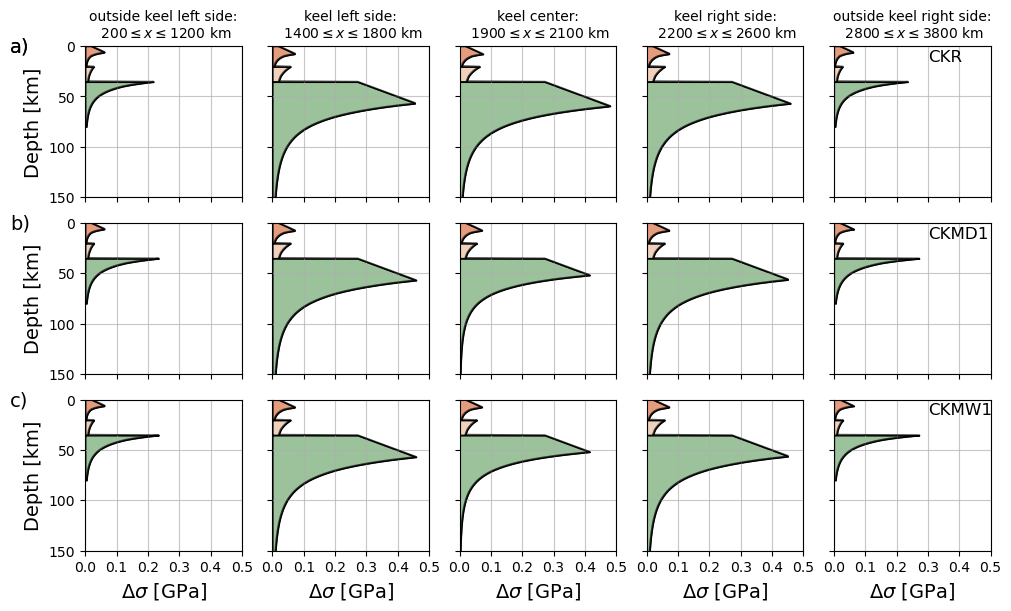

In [40]:
# instants = [0, 500, 1000] #Myr
instants = [1000]


##############################################################################################################
#Creating figure and subplots
plt.close()
# gridspec_kw={'height_ratios':[0.3,0.5]}


fig_length = 10
fig_height = 6 #6 minimum

if(len(instants) > 1):
#     fig_height = (2.0)*(len(instants) + 1) #4 is minimum

    fig, axs = plt.subplots(len(instants)*len(scenarios), 5, figsize=(fig_length, fig_height), sharex=True, sharey=True, constrained_layout=True)
else:
    fig, axs = plt.subplots(len(instants)*len(scenarios), 5, figsize=(fig_length, fig_height), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten() #flatten the axs array to make it easier to iterate over the subplots

alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(instants)]

Lcraton = 1200.0 #km
shift = 0.0 #km

Hlits = [80.0e3, 200.0e3, 200.0e3, 200.0e3, 80.0e3]
thickness_sa = 40.0e3
z_aux = z - thickness_sa/1.0e3
cond_aux = z_aux >= 0
Lcraton = 1200.0 #km
xcenter = (Lx/2)/1.0e3 + shift/1.0e3

# time = np.round(dataset0.time[i].values, 2)

for instant, i in zip(instants, range(len(instants))):
    idx = find_nearest(dataset0.time, instant)

    data0 = dataset0.temperature[idx].values.T #Nz vs Nx
    data1 = dataset1.temperature[idx].values.T #Nz vs Nx
    data2 = dataset2.temperature[idx].values.T #Nz vs Nx
    
    temperature_profiles0 = calc_temper_profiles(data0, Lx, Nz, xx)
    temperature_profiles1 = calc_temper_profiles(data1, Lx, Nz, xx)
    temperature_profiles2 = calc_temper_profiles(data2, Lx, Nz, xx)

    for ax0, ax1, ax2, temp_profile0, temp_profile1, thickness_litho in zip(axs[0:len(Hlits)], axs[len(Hlits): 2*len(Hlits)], axs[2*len(Hlits): 3*len(Hlits)], temperature_profiles0, temperature_profiles1, Hlits):
        calc_and_plot_YSE(ax0, temp_profile0[cond_aux], z_aux[cond_aux], thickness_litho=thickness_litho)
        calc_and_plot_YSE(ax1, temp_profile1[cond_aux], z_aux[cond_aux], thickness_litho=thickness_litho)
        calc_and_plot_YSE(ax2, temp_profile1[cond_aux], z_aux[cond_aux], thickness_litho=thickness_litho)

        # ax0.plot(range(10), range(10), color='k')
        # ax1.plot(range(10), range(10), color='r')


locations = [f'outside keel left side:\n $200 \leq x \leq {int(xcenter - 800)}$ km',
             f'keel left side:\n ${int(xcenter - 600)} \leq x \leq {int( xcenter - 200)}$ km',
             f'keel center:\n ${int(xcenter - 100)} \leq x \leq {int( xcenter + 100)}$ km',
             f'keel right side:\n ${int(xcenter + 200)} \leq x \leq {int( xcenter + 600)}$ km',
             f'outside keel right side:\n ${int(xcenter + 800)} \leq x \leq {int(Lx/1.0e3 - 200)}$ km'
             ]

label_fsize = 14
for ax0, ax1, ax2, location in zip(axs[0:len(Hlits)], axs[len(Hlits): 2*len(Hlits)], axs[2*len(Hlits): 3*len(Hlits)], locations):
    ax0.grid("k", alpha=0.7)
    ax1.grid("k", alpha=0.7)
    ax2.grid("k", alpha=0.7)
    ax0.set_title(f'{location}', fontsize=10)
    ax2.set_xlabel(r'$\Delta\sigma$ [GPa]', fontsize=label_fsize)

xpos = -0.48
ypos = 0.995
fsize = 14
axs[0].text(xpos, ypos, 'a)', color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[0].transAxes)

axs[len(Hlits)].text(xpos, ypos, 'b)', color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[len(Hlits)].transAxes)

axs[2*len(Hlits)].text(xpos, ypos, 'c)', color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[2*len(Hlits)].transAxes)

axs[0].text(xpos, ypos, 'a)', color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[0].transAxes)

xpos = 0.6
ypos = 0.93
fsize = 12

axs[len(Hlits)-1].text(xpos, ypos, r'CKR', color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[len(Hlits)-1].transAxes)

axs[2*len(Hlits)-1].text(xpos, ypos,  r'CKMD1', color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[2*len(Hlits)-1].transAxes)

axs[3*len(Hlits)-1].text(xpos, ypos,  r'CKMW1', color='k', fontsize=fsize,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[3*len(Hlits)-1].transAxes)


# for ax in axs:
#     ax.set_box_aspect(3)

axs[0].set_xlim([0, 0.5])
axs[0].set_xticks(np.linspace(0, 0.5, 6))

# axs[0].set_ylim([200, 0])
# axs[0].set_yticks(np.linspace(0, 200, 11))
    
# axs[0].set_xlim([0, 0.5])
axs[0].set_ylim([150, 0])

axs[0].set_ylabel('Depth [km]', fontsize=label_fsize)
axs[len(Hlits)].set_ylabel('Depth [km]', fontsize=label_fsize)
axs[2*len(Hlits)].set_ylabel('Depth [km]', fontsize=label_fsize)

filename = "YSE_final_Ref_vs_Mbdo_vs_Mbwo"
fig.savefig(f"figures/{filename}.png", dpi=300)
fig.savefig(f"figures/{filename}.pdf", dpi=300)

Text(0, 0.5, 'Depth [km]')

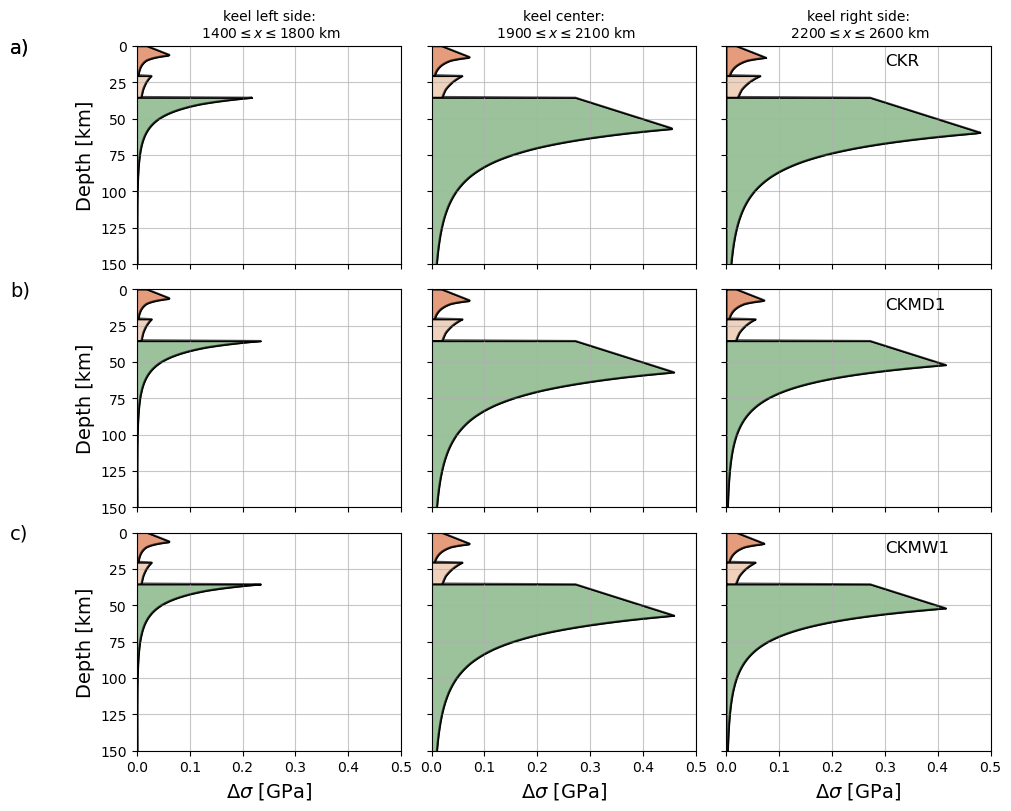

In [72]:
# plt.close()
# # gridspec_kw={'height_ratios':[0.3,0.5]}
# if(len(instants) > 1):
#     fig_height = (3.0/2.0)*(len(instants) + 2) #6 minimum
# #     fig_height = (2.0)*(len(instants) + 1) #4 is minimum

#     fig, axs = plt.subplots(len(instants)*2, 5, constrained_layout=True, figsize=(8, fig_height), sharex=True, sharey=True)
# else:
#     fig, axs = plt.subplots(len(instants)*2, 5, constrained_layout=True, figsize=(12,4), sharex=True, sharey=True)
# axs = axs.flatten()

# axs[9].plot(range(10), range(10))